# 주식 예측에 도전해 보자
---

과거 주식 데이터를 바탕으로 미래의 주식 시세를 에측해보자.

## Background Knowledge
---

### ARIMA
- Autoregressive Integrated Moving Average
- AR, I, MA가 합쳐진 모델

1. AR
    - 자기회귀, Autoregressive
    - 시계열 데이터 $Y = \lbrace Y_t: t ∈ T \rbrace$에 대하여, $Y_t$가 이전 p개의 데이터 $Y_{t-1}, Y_{t-2}, ..., Y_{t-p}$의 가중합으로 수렴한다고 보는 모델
    - 자신의 시점(Y) 이전의 데이터들($Y_{t-1}, Y_{t-2}, ..., Y_{t-p}$)을 X로 삼는다고 볼 수 있다.
    - Residual
2. MA
    - 이동평균, Moving Average
    - 시계열 데이터 $Y = \lbrace Y_t: t ∈ T \rbrace$에 대하여, $Y_t$가 이전 q개의 예측오차값 $e_{t-1}, e_{t-2}, ..., e_{t-q}$의 가중합으로 수렴한다고 보는 모델
    -  t 시점의 데이터를 t 시점의 에러와 그 과거의 에러들로 표현
    - 연속적인 error term으로 Y와의 관계를 표현
    - Trend
3. I
    - 차분누적, Integration
    -  $Y_t$이 이전 데이터와 d차 차분의 누적(integration) 합이라고 보는 모델
    -  Seasonality

#### AFC
- Autocorrelation Function
- ARIMA의 모수 p를 선택하는데 사용되는 함수로, 시차(lang)에 따른 다른 관측치 사이의 관련성을 나타낸다.
- ACF Lag 1의 값은 현재 데이터와 한 시점 미룬(shift) 데이터와의 correlation을 의미하낟.
- 그래프가 특정한 패턴이 없고 랜덤한 경우라면 source가 된 데이터는 안정적이라 할 수 있다.
- 그래프가 지수 혹은 선형적으로 줄어들거나 사인함수 모양으로 패턴이 반복되는 형태라면 source가 된 데이터는 불안정적이다.

### Box-Jenkins ARIMA Procedure
![box jenkins](./assets/01_box_jenkins.png)

1. Data Preprocessing : transformation, differencing 
    - non-stationary data -> stationary data
    - ACF의 전개 확인 : non-stationary라면 lag(2)를 기준으로 값이 점차적으로 떨어진다.
    - p-value 확인 : non-stataionary라면 값이 0.05 이상이다.
 2. Identify Model to be tentatively Entertained
     - 초기 모델 선정
     - Graphical method : making inferences from the patterns of the sample autocorrelation and partial autocorrelation functions of the series(=time series data). -> data의 ACF, FACF의 패턴을 보고 결정
     
| Model | ACF | partial ACF |
| :-----:|:-----|:----------|
| MA(q) | Cut off after lag q<br>(q 시차 이후 0으로 절단 <br> = lag q 이후에 확 떨어졌다) | Die out<br>(지수적으로 감소, 소멸하는 sine 함수 형태) |
| AR(p) | Die out<br>(지수적으로 감소, 소멸하는 sine 함수 형태) | Cut off after lag p<br>(p시차 이후 0으로 절단) |
| ARMA(p,q) | Die out<br>(시차 (q-p) 이후부터 소멸) | Die out<br>(시차 (q-p) 이후부터 소멸) |
         
<img src="./assets/02_acf.png" width=70%/>
3. Estimate Parameters
    - 선정한 초기모델을 기준으로 주변의 모델들을 함께 비교하고 지표가 가장 좋은 것을 선택
        - (p, d, q)의 조합을 Grid Search를 돌린 후 확인하여 prediction error가 가장 낮은 값을 선정한다. 
    - 이것도 확정은 아님!
4. Diagnosis Check
    - 모델 평가 : 모델과 파라미터가 적절한지 판단.
    - 적절하면 5로 이동, 그렇지 않다면 2로 이동
    - 잔차의 AFC plot을 생성하고, 이 값들이 특정 bound(residual의 분산 * 3)안에 존재하면(40개의 샘플 중 2~3개만 벗어난 경우) 모델 채택
5. Use Model to Forecast


계절적 특성을 살리고 싶다면 Seanal ARIMA Model을 사용할 수 있다.

## STEP 0. 설계
---

다음과 같은 순서로 프로젝트를 진행한다.

1. 자료 수집 : [Yahoo Finance](https://finance.yahoo.com/)에서 여러 기업의 국내 주식 데이터를 다운로드 받는다.
    - 데이터는 홈페이지에서 기업 검색 > Historical Data > Time Period : Max > Apply > Download 순서로 다운로드 받는다.
2. Preprocessing
    - 수집한 주식데이터에서 종가(Close)만을 사용하여 시계열 데이터를 뽑아낸다.
    - 결측치를 처리
    - 정규화 : 로그변환
3. Stationary 분석
    - 정성적 그래프 분석
    - Augmented Dicky-Fuller Test
    - 시계열 분해(Time Series Decomposition)
        - Residual 안정성 확인
4. 학습, 테스트 데이터셋 생성
    - 학습, 테스트 데이터셋 분리
5. 적정 ARIMA 모수 찾기
    - ACF, PACF 그려보기 -> p,q 구하기
    - 차분 안정성 확인 -> d 구하기
6. ARIMA 모델 훈련과 테스트
    - ARIMA 모델 빌드와 훈련
    - 모델 테스트 및 플로팅
    - 최종 예측 모델 정확도 측정(MAPE)
7. 다른 주식 종목 예측해 보기

## STEP 1. 데이터 수집
---

- 데이터 수집

Yahoo Finance에서 총 6개 기업에 대한 주가 데이터를 다운로드 받았다.

In [1]:
!ls ./data/stock

003230.KS.csv  005930.KS.csv  035420.KS.csv  036570.KS.csv  KOSPI.csv  SNP.csv
004370.KS.csv  007310.KS.csv  035720.KS.csv  FB.csv	    NFLX.csv


In [2]:
filename_to_companyname = {
    '005930.KS': 'Samsung Electronics',
    '004370.KS': 'Nongshim',
    '007310.KS' : 'Ottogi Corporation',
    '036570.KS' : 'Ncsoft Corporation',
    'NFLX' : 'Netflix',
    'FB' : 'Facebook'
}

- 데이터 불러오기

In [3]:
import pandas as pd
import os

stock_data_dir_path = os.getenv('HOME') + '/workspace/aiffel-exploration-workspace/E13_arima/data/stock'
dataset = {}
for code in filename_to_companyname:
    df = pd.read_csv(f'{stock_data_dir_path}/{code}.csv', parse_dates=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    dataset[code] = df
    
print(f'dataset size : {len(dataset)}\n\n')
display(dataset['005930.KS'])

dataset size : 6




,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0
...,...,...,...,...,...,...
2021-02-22,83800.0,84200.0,82200.0,82200.0,82200.000000,25419886.0
2021-02-23,81200.0,82900.0,81100.0,82000.0,82000.000000,20587314.0
2021-02-24,81800.0,83600.0,81300.0,82000.0,82000.000000,26807651.0


## STEP 2. Code Collection
---

여섯개의 데이터 셋이 대하여 동일한 분석을 반복적으로 진행해야하기 때문에 필요한 함수들을 먼저 정의하도록 한다.

#### environment setting

In [4]:
import os
from os.path import join

import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.simplefilter(action='ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error

from tqdm.notebook import tqdm

#### 결측치 처리 - 보간

In [5]:
def handle_missing_value(serise, verbose=2):
    if verbose > 1 : 
        print(f'[handle missing value] BEFORE interplation')
        display(serise[serise.isna()])
    
    serise_interpolated = serise.interpolate(method='time') 
    
    if verbose > 1 :
        print(f'[handle missing value] AFTER interplation')
        display(serise_interpolated[serise.isna()])
        print(f'Number of NAN After Interplation : {serise_interpolated.isna().sum()}\n\n')
    
    return serise_interpolated

#### 시계열 데이터 출력

In [6]:
def show_series_plt(timeseries):
    plt.plot(timeseries)

#### 정성적 분석 - 시간 내 구간 통계치 포함

In [7]:
def plot_rolling_statistics(timeseries, code, window=12):
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'[{code}] Rolling Mean & Standard Deviation')
    plt.show(block=False) 

#### Augmented Dicky-Fuller Test

In [8]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#### 시계열 분해

In [9]:
def time_series_decomposition(timeseries, model='multiplicative', period=12, verbose=2):
    decomposition = seasonal_decompose(timeseries, model=model, period=period)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    if verbose > 1 :
        fig, axs = plt.subplots(4, 1, figsize=(11, 6))
        
        axs[0].plot(timeseries, label='Original')
        axs[0].legend()

        axs[1].plot(trend, label='Trend')
        axs[1].legend()
        
        axs[2].plot(seasonal,label='Seasonality')
        axs[2].legend()
        
        axs[3].plot(residual, label='Residuals')
        axs[3].legend()
        
        plt.tight_layout()
        plt.show()
        
    return trend, seasonal, residual

#### ACF, PACF 출력

In [10]:
def show_acf_pacf(timeserise):
    fig, axs = plt.subplots(2, 1, figsize=(13, 8))
    plot_acf(timeserise, axs[0])
    plot_pacf(timeserise, axs[1])
    plt.show()

#### 차분

In [11]:
def differencing(timeseries, verbose=0):
    diff = timeseries.diff(periods=1).iloc[1:]
    
    if verbose > 1:
        diff.plot(title='Differencing')
        
    if verbose > 0:
        augmented_dickey_fuller_test(diff)
        
    return diff

#### 학습데이터 분리

In [12]:
def split_train_and_test(timeseries, train_ratio=0.9, verbose=1):
    train_size = int(len(timeseries)*train_ratio)
    train_data, test_data = timeseries[:train_size], timeseries[train_size:]
    
    if verbose > 1:
        plt.figure(figsize=(10,6))
        plt.grid(True)
        plt.plot(train_data, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
        plt.plot(test_data, c='b', label='test dataset')
        plt.legend()
        plt.show()
        
    return train_data, test_data

#### ARIMA 모델 훈련

In [13]:
def train_arima(train_data, order, verbose=2, exog=None):
    if exog is not None:
        model = ARIMA(train_data, order=order, exog=exog)
    else : 
        model = ARIMA(train_data, order=order) 
        
    fitted_m = model.fit(disp=-1)
    
    if verbose > 1:
        print(fitted_m.summary())
        fitted_m.plot_predict()
        plt.show()
    
    return fitted_m

#### ARIMA 모델 예측

In [14]:
def predict_arima(fitted_m, test_data, train_data=None, verbose=1, exog=None,):
    # Forecast : 결과가 fc에 담깁니다. 
    # 95% conf
    # The confidence intervals for the forecasts are (1 - alpha) %
    if exog is not None: 
        fc, se, conf = fitted_m.forecast(len(test_data), exog=exog, alpha=0.05)
    else:
        fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    if verbose > 1 and train_data is not None:
        plt.figure(figsize=(11,5))
        plt.plot(train_data, label='training')
        plt.plot(test_data, c='b', label='actual price')
        plt.plot(fc_series, c='r',label='predicted price')
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
        plt.legend()
        plt.show()
    
    return fc_series, lower_series, upper_series

#### 예측 모델 정확도 측정

In [15]:
def get_model_accuracy(test_data, fc, verbose=2):
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))

    if verbose > 1:
        print('MSE: ', mse)
        print('MAE: ', mae)
        print('RMSE: ', rmse)
        print('MAPE: {:.2f}%'.format(mape*100))

    return { 
        'MSE' : mse,
        'MAE' : mae,
        'RMSE' : rmse,
        'MAPE' : mape
    }

#### ARIMA 모수 Grid search

In [36]:
def grid_search(train_data, test_data, p_range, d, q_range, exog_train=None, exog_test=None, verbose=0):
    scores = pd.DataFrame([], columns = ['p' , 'd', 'q', 'RMSE', 'MAPE'])
    orders = [(p, d, q) for p in p_range for q in q_range ]

    for order in tqdm(orders):
        try:
            if exog_train is not None and exog_test is not None:
                tmp_m = train_arima(train_data, order, exog=exog_train, verbose=0)
                fc_series_tmp, _, _ = predict_arima(tmp_m, test_data, exog=exog_test, verbose=0)
            else:
                tmp_m = train_arima(train_data, order, 0)
                fc_series_tmp, _, _ = predict_arima(tmp_m, test_data, verbose=0)
            tmp_m_acc = get_model_accuracy(test_data, fc_series_tmp, 0)

            scores = scores.append({
                'p' : order[0],
                'd' : order[1],
                'q': order[2],
                'RMSE' : tmp_m_acc['RMSE'],
                'MAPE' : tmp_m_acc['MAPE']
            }, ignore_index=True)
        except ValueError:
            continue
            
    scores = scores.convert_dtypes()
    
    if verbose > 1:
        pivot_ = scores.pivot(index='p', columns='q', values='MAPE')
        plt.figure(figsize=(7,5))
        plt.title('Grid Search for (p, 1, q) Result', fontsize=15, pad=20)
        sns.heatmap(pivot_, annot=True, fmt=".4f", cmap='viridis')
        plt.show()
    
    return scores

## STEP 3. Preprocessing
---

### 1. 시계열 데이터 추출
- 주식 데이터(DataFrame)에서 종가(Close)만을 추출하여 Series 데이터를 변수에 저장한다.

In [17]:
timeseries = { code : df['Close'] for code, df in dataset.items()}
print('005930.KS\n=========================')
print(timeseries['005930.KS'])

005930.KS
Date
2000-01-04     6110.0
2000-01-05     5580.0
2000-01-06     5620.0
2000-01-07     5540.0
2000-01-10     5770.0
               ...   
2021-02-22    82200.0
2021-02-23    82000.0
2021-02-24    82000.0
2021-02-25    85300.0
2021-02-26    82500.0
Name: Close, Length: 5318, dtype: float64


### 2. 결측치 처리
- 보간법을 이용하여 결측값을 보간해 준다.

In [18]:
timeseries = {code : handle_missing_value(ts) for code, ts in timeseries.items()}

[handle missing value] BEFORE interplation


Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

[handle missing value] AFTER interplation


Date
2005-01-03     8957.5
2017-11-16    55580.0
2017-11-23    55710.0
2018-01-02    51510.0
2018-11-15    44050.0
2019-11-14    53100.0
Name: Close, dtype: float64

Number of NAN After Interplation : 0


[handle missing value] BEFORE interplation


Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

[handle missing value] AFTER interplation


Date
2005-01-03    243875.000000
2017-11-16    345000.000000
2017-11-23    365000.000000
2018-01-02    349416.666667
2018-11-15    242000.000000
2019-11-14    246750.000000
Name: Close, dtype: float64

Number of NAN After Interplation : 0


[handle missing value] BEFORE interplation


Date
2005-01-03   NaN
2008-05-01   NaN
2008-05-05   NaN
2008-05-12   NaN
2008-06-06   NaN
2008-08-15   NaN
2008-09-15   NaN
2008-10-03   NaN
2008-12-25   NaN
2008-12-31   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

[handle missing value] AFTER interplation


Date
2005-01-03     46162.5
2008-05-01    153500.0
2008-05-05    153125.0
2008-05-12    148375.0
2008-06-06    153625.0
2008-08-15    157000.0
2008-09-15    146125.0
2008-10-03    158500.0
2008-12-25    136500.0
2008-12-31    143000.0
2017-11-16    771000.0
2017-11-23    802000.0
2018-01-02    801000.0
2018-11-15    698000.0
2019-11-14    573500.0
Name: Close, dtype: float64

Number of NAN After Interplation : 0


[handle missing value] BEFORE interplation


Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

[handle missing value] AFTER interplation


Date
2005-01-03     82900.000000
2017-11-16    427000.000000
2017-11-23    456500.000000
2018-01-02    437083.333333
2018-11-15    462000.000000
2019-11-14    536000.000000
Name: Close, dtype: float64

Number of NAN After Interplation : 0


[handle missing value] BEFORE interplation


Series([], Name: Close, dtype: float64)

[handle missing value] AFTER interplation


Series([], Name: Close, dtype: float64)

Number of NAN After Interplation : 0


[handle missing value] BEFORE interplation


Series([], Name: Close, dtype: float64)

[handle missing value] AFTER interplation


Series([], Name: Close, dtype: float64)

Number of NAN After Interplation : 0




### 3. 로그 변환
- 로그 변환을 통하여 데이터를 정규화한다.

In [19]:
timeseries = {code : np.log(ts) for code, ts in timeseries.items()}
timeseries['005930.KS'].head()

Date
2000-01-04    8.717682
2000-01-05    8.626944
2000-01-06    8.634087
2000-01-07    8.619750
2000-01-10    8.660427
Name: Close, dtype: float64

## STEP 4. ARIMA Procedure
---

⚠️ 문서의 일관성을 위하여 이후 단계는 데이터별로 구분하여 진행한다.

### 005930.KS - Samsung Electronics

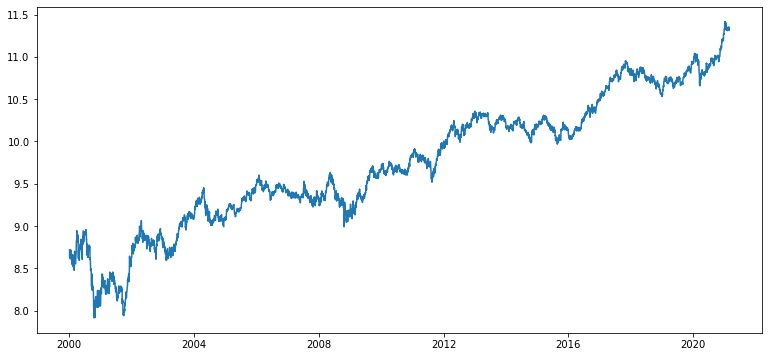

In [20]:
code_ss = '005930.KS'
show_series_plt(timeseries[code_ss])

#### 1. 데이터 안정성 분석
- 정성적 그래프 분석

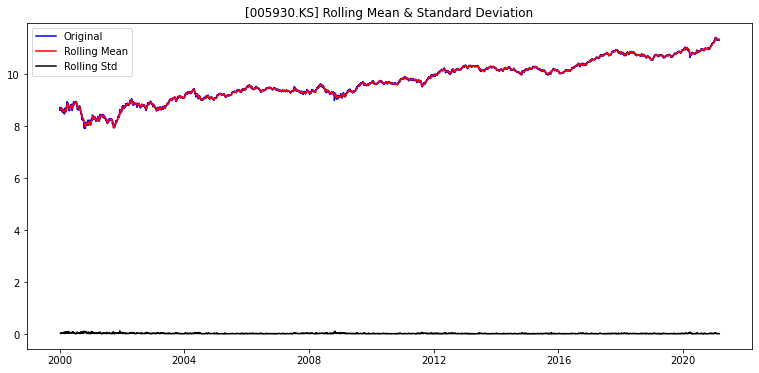

In [21]:
plot_rolling_statistics(timeseries[code_ss], code_ss, window=7)

그래프상으로 평균은 점진적으로 증가하고, 분산은 일정하므로 데이터는 현재 안정적이지 않은 상태이다.

- Augmented Dicky-Fuller Test

In [22]:
augmented_dickey_fuller_test(timeseries[code_ss])

Results of Dickey-Fuller Test:
Test Statistic                   -0.325391
p-value                           0.921830
#Lags Used                        4.000000
Number of Observations Used    5313.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


ADFTest의 결과 p-value가 0.05 미만의 낮은 값을 가지지 않으므로, 이 결과로 데이터가 안정적임을 확인 할 수 없다.

- 시계열 분해(Time Series Decomposition)

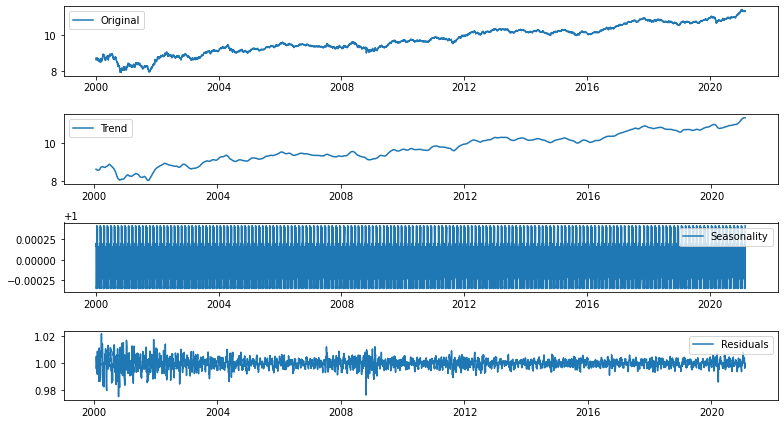

In [23]:
trend, seasonal, residual = time_series_decomposition(timeseries[code_ss], period=30)

- Residual 분석

In [24]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.759298e+01
p-value                        3.955529e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.254000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


#### 2. 학습, 테스트 데이터셋 생성

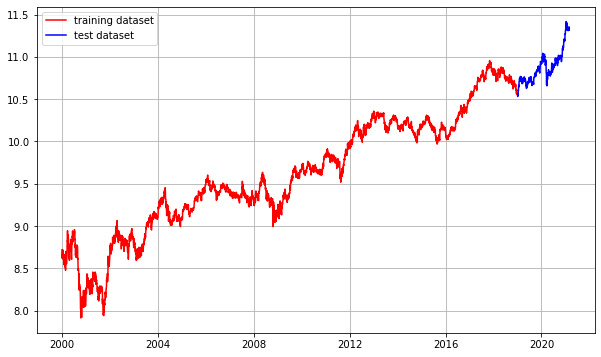

In [25]:
train_data_ss, test_data_ss = split_train_and_test(timeseries[code_ss], verbose=2)

#### 3. 초기 ARIMA 모수 찾기
- ACF, PACF

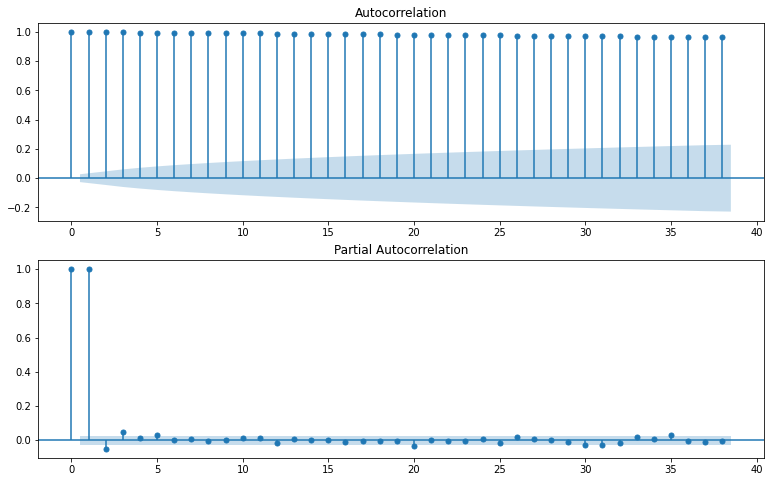

In [26]:
show_acf_pacf(timeseries[code_ss])

ACF를 보면, 값이 천천히 감소하는 형태를 보인다.<br/>
PACF의 경우 lag 2 이후로, 값이 0으로 절단 된 형태를 보인다.<br/>
따라서 AR을 초기모델로 선정하며, 모수의 초기값은 *p=1, q=0* 이 적절하다.

- Differencing

Results of Dickey-Fuller Test:
Test Statistic                  -40.102097
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5313.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


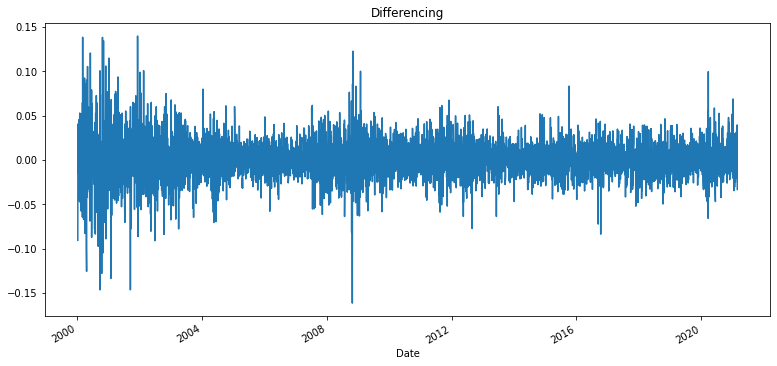

In [27]:
diff_1_ss = differencing(timeseries[code_ss], 2)

일차 차분의 결과의 *p-value*는 0으로 충분히 안정화된 상태가 되었으므로 *d*의 초기값으로는 *1*이 적절하다.

#### 4. ARIMA 모델 훈련과 테스트

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4785
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11277.411
Method:                       css-mle   S.D. of innovations              0.023
Date:                Wed, 03 Mar 2021   AIC                         -22548.823
Time:                        23:53:40   BIC                         -22529.403
Sample:                             1   HQIC                        -22542.001
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.111      0.266      -0.000       0.001
ar.L1.D.Close     0.0437      0.014      3.018      0.003       0.015       0.072
                                    Root

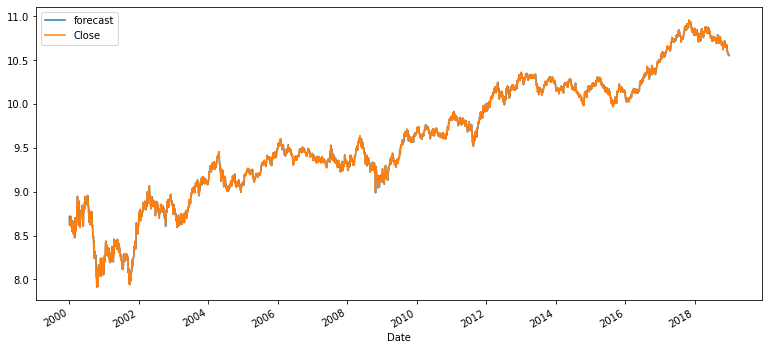

In [28]:
fitted_m_ss = train_arima(train_data_ss, (1, 1, 0))

- 모델 테스트 및 플로팅

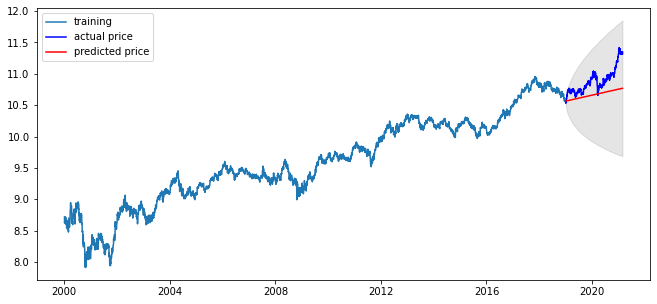

In [29]:
fc_series_ss, lower_series_ss, upper_series_ss = predict_arima(fitted_m_ss, test_data_ss,
                                                               train_data=train_data_ss,
                                                               verbose=2)

- 예측 모델 정확도 측정

In [30]:
_ = get_model_accuracy(test_data_ss, fc_series_ss)

MSE:  214746718.1936507
MAE:  11296.361407681165
RMSE:  14654.238915537398
MAPE: 18.68%


MAPE 값이 18.68%로 목표치인 10%와의 차이가 크므로 모델을 개선할 필요가 있다. 

#### 5. 모델개선
📝 모수 재설정을 위한 **grid search** 수행

  0%|          | 0/36 [00:00<?, ?it/s]

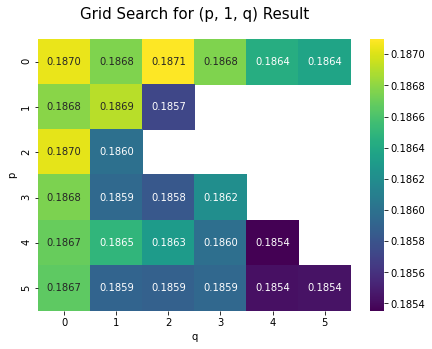

In [38]:
gride_search_scores_1 = grid_search(train_data_ss, test_data_ss, range(6), 1, range(6), verbose=2)

  0%|          | 0/25 [00:00<?, ?it/s]

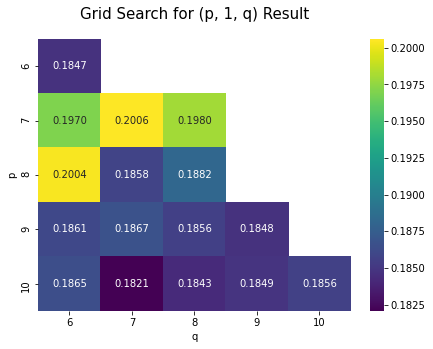

In [39]:
gride_search_scores_2 = grid_search(train_data_ss, test_data_ss, range(6, 11), 1, range(6, 11), verbose=2)

  0%|          | 0/4 [00:00<?, ?it/s]

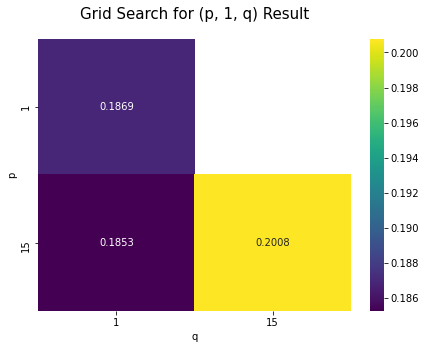

In [40]:
gride_search_scores_3 = grid_search(train_data_ss, test_data_ss, [1, 15], 1, [1, 15], verbose=2)

p와 q를 [0. 10] 범위에서 gride search를 수행한 결과 (p, q) = (10, 7)일 때, MAPE = 18.21%로 가장 낮은 수치를 기록하였다.

📝 **외생변수** 추가<br>
주식 데이터는 자신의 과거 추세 보다는 외부의 요인에 더 큰 영향을 받는다. KOSPI 지수를 외생변수로 넣어 모델을 개선해보자 -> *ARIMAX*

- KOSPI 데이터 불러오기

In [41]:
kospi_df = pd.read_csv(f'{stock_data_dir_path}/KOSPI.csv', parse_dates=True)
kospi_df['Date'] = pd.to_datetime(kospi_df['Date'])
kospi_df = kospi_df.set_index('Date')
kospi_ts = kospi_df['Close']
kospi_ts = handle_missing_value(kospi_ts, verbose=0)
kospi_ts = np.log(kospi_ts)

# train / test 데이터 분리
train_kospi_ts = kospi_ts.iloc[lambda x : x.index.isin(train_data_ss.index)]
test_kospi_ts = kospi_ts.iloc[lambda x : x.index.isin(test_data_ss.index)]

print(f'KOSPI timeserise - train : {train_kospi_ts.shape}')
print(f'KOSPI timeserise - test : {test_kospi_ts.shape}')

KOSPI timeserise - train : (4786,)
KOSPI timeserise - test : (532,)


- ARIMA 모델 학습 : (p, d, q) = (1, 1, 0)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4785
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11277.669
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 04 Mar 2021   AIC                         -22547.338
Time:                        02:21:12   BIC                         -22521.446
Sample:                             1   HQIC                        -22538.243
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0035      0.005     -0.644      0.519      -0.014       0.007
Close             0.0005      0.001      0.717      0.473      -0.001       0.002
ar.L1.D.Close     0.0437      0.014     

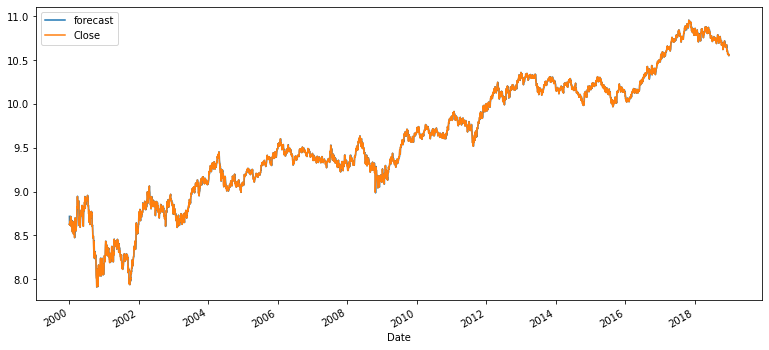

In [43]:
fitted_m_ss_arimax = train_arima(train_data_ss, (1,1,0), exog=train_kospi_ts)

- 예측

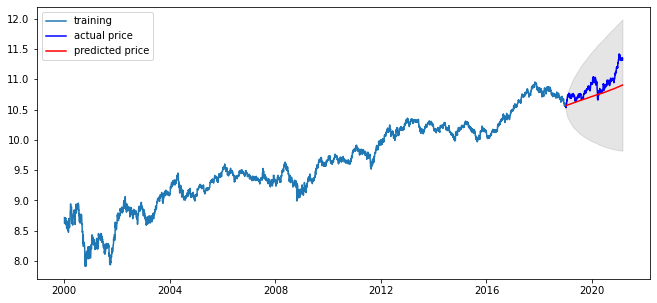

In [45]:
fc_series_ss_arimax, lower_series_ss_arimax, upper_series_ss_arimax = predict_arima(fitted_m_ss_arimax, 
                                                                                    test_data_ss, 
                                                                                    exog=test_kospi_ts,
                                                                                    train_data=train_data_ss,
                                                                                    verbose=2)

- 예측 결과의 정확도 평가

In [47]:
_ = get_model_accuracy(test_data_ss, fc_series_ss_arimax)

MSE:  134413841.11475676
MAE:  8458.41291164699
RMSE:  11593.698336370357
MAPE: 13.82%


- Grid Search를 통한 모수 탐색

  0%|          | 0/36 [00:00<?, ?it/s]

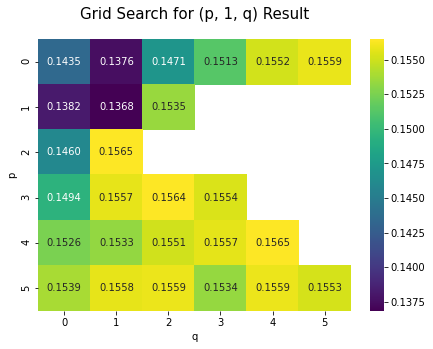

In [48]:
gride_search_scores_arimax_1 = grid_search(train_data_ss, 
                                           test_data_ss, 
                                           range(6), 1, range(6), 
                                           exog_train=train_kospi_ts, 
                                           exog_test=test_kospi_ts, 
                                           verbose=2)

p와 q를 [0. 5] 범위에서 gride search를 수행한 결과 (p, q) = (1, 1)일 때, MAPE = 13.68%로 가장 낮은 수치를 기록하였다.

📝 **EDA**<br>
ARIMA 모델의 예측은 긴 기간을 예측할수록 그 정확도가 떨어진다고 한다. 사용되고 있는 train data의 수는 4786, test datae의 수는 532이다. 1년이 넘는 기간을 예측하고 있는데, 이를 30으로 줄여 *한달을 예측*하도록 데이터의 구성을 변경하여 보자.

- 훈련 / 테스트 데이터셋 재분배

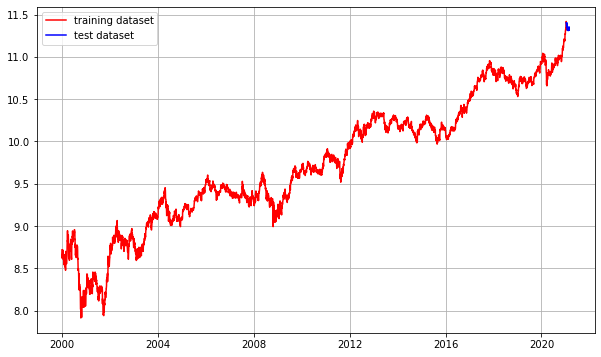

((5287,), (31,))

In [66]:
train_data_ss_2, test_data_ss_2 = split_train_and_test(timeseries[code_ss],
                                                       train_ratio=0.9943,
                                                       verbose=2)
train_data_ss_2.shape, test_data_ss_2.shape

- 모델 학습 및 평가

In [56]:
# 모델 훈련과 테스트
fitted_m_ss_2 = train_arima(train_data_ss_2, (1, 1, 0), verbose=0)

#모델 테스트 및 플로팅
fc_series_ss_2, _, _ = predict_arima(fitted_m_ss_2, test_data_ss_2, verbose=0)

#예측 모델 정확도 측정
_ = get_model_accuracy(test_data_ss_2, fc_series_ss_2)

MSE:  51948477.1698362
MAE:  6638.764975120726
RMSE:  7207.529200068231
MAPE: 7.94%


- Grid Search를 통한 모수 탐색

  0%|          | 0/36 [00:00<?, ?it/s]

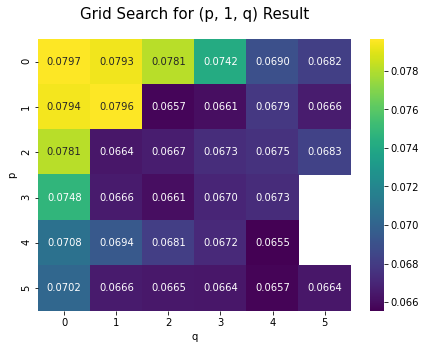

In [65]:
# grid searh
gride_search_scores_eda_1 = grid_search(train_data_ss_2, 
                                        test_data_ss_2, 
                                        range(6), 1, range(6), 
                                        verbose=2)

In [67]:
# 탐색된 모수를 이용한 재학습
fitted_m_ss_3 = train_arima(train_data_ss_2, (5, 1, 4), verbose=0)

#모델 테스트 및 플로팅
fc_series_ss_3, _, _ = predict_arima(fitted_m_ss_3, test_data_ss_2, verbose=0)

#예측 모델 정확도 측정
_ = get_model_accuracy(test_data_ss_2, fc_series_ss_3)

MSE:  37493618.931912884
MAE:  5480.909110670386
RMSE:  6123.2033227643915
MAPE: 6.57%


#### summary
- 삼성전자의 주식 데이터를 활용하여 미래의 주식가격을 예측하는 ARIMA 모델을 구축하였다.
- 아래과 같은 시도들을 하였고, 각 시도마다 계산된 MAPE 값도 함께 나열하였다.

| 시도 | 데이터 처리 | p, d, q  | MAPE(%) |
|:-----|----------|:-------|:-----:|
| ARIMA 초기 모델 | 정규화(로그변환)<br> train : test = 9 : 1 | 1,1,0 | 18.68 | 
| Grid Search | 정규화(로그변환)<br> train : test = 9 : 1  | 찾아낸 optimal : 10, 1, 7 | 18.21 |
| ARIMAX, 외생변수(KOSPI) 추가 | 정규화(로그변환)<br> train : test = 9 : 1 | 1, 1, 0 | 13.82 |
| ARIMAX, Grid Search | 정규화(로그변환)<br> train : test = 9 : 1 | 1, 1, 0 | 13.68 |
| EDA | 정규화(로그변환)<br> train : test = 5287 : 31 | 1, 1, 0 | 7.94 |
| EDA, Grid Search | 정규화(로그변환)<br> train : test = 5287 : 31 | 찾아낸 optimal : 5, 1, 4 | 6.57 |

### 004370.KS - Nongshim

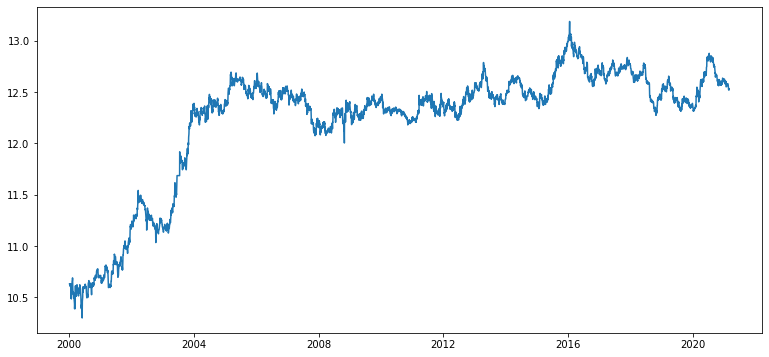

In [68]:
code_nongsim = '004370.KS'
show_series_plt(timeseries[code_nongsim])

#### 1. 데이터 안정성 분석
- 정성적 그래프 분석

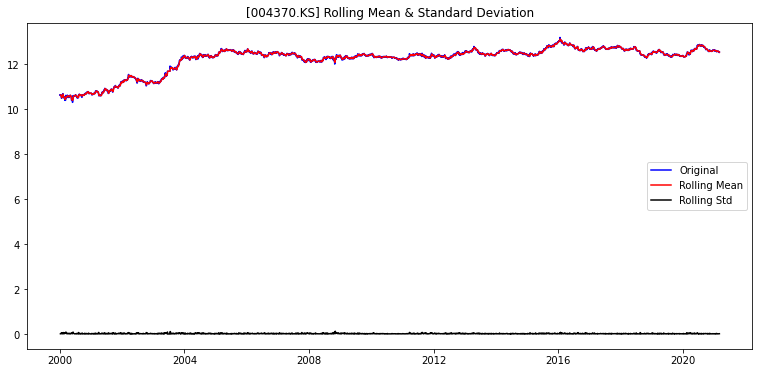

In [71]:
plot_rolling_statistics(timeseries[code_nongsim], code_nongsim, window=5)

그래프상으로 평균은 점진적으로 증가하고, 분산은 일정하므로 데이터는 현재 안정적이지 않은 상태이다.

- Augmented Dicky-Fuller Test

In [72]:
augmented_dickey_fuller_test(timeseries[code_nongsim])

Results of Dickey-Fuller Test:
Test Statistic                   -2.548427
p-value                           0.104131
#Lags Used                        2.000000
Number of Observations Used    5317.000000
Critical Value (1%)              -3.431580
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567059
dtype: float64


ADFTest의 결과 p-value가 0.05 미만의 낮은 값을 가지지 않으므로, 이 결과로 데이터가 안정적임을 확인 할 수 없다.

- 시계열 분해(Time Series Decomposition)

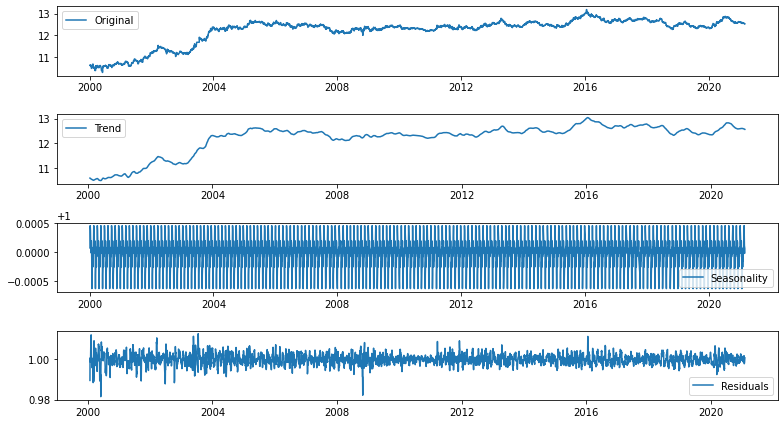

In [76]:
trend, seasonal, residual = time_series_decomposition(timeseries[code_nongsim], period=30)

- Residual 안정성 확인

In [77]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.857446e+01
p-value                        2.080952e-30
#Lags Used                     3.200000e+01
Number of Observations Used    5.257000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


#### 2. 학습, 테스트 데이터셋 생성

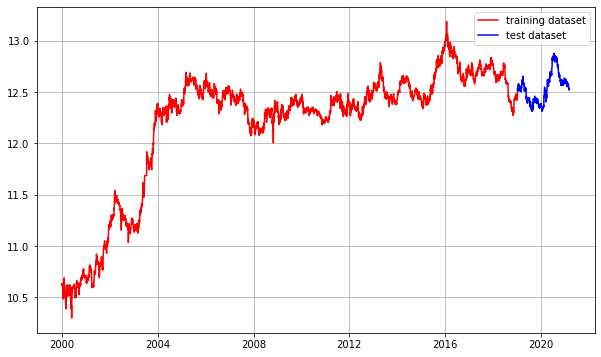

In [78]:
train_data_nongsim, test_data_nongsim = split_train_and_test(timeseries[code_nongsim], verbose=2)

#### 3. 초기 ARIMA 모수 찾기
- ACF, PACF

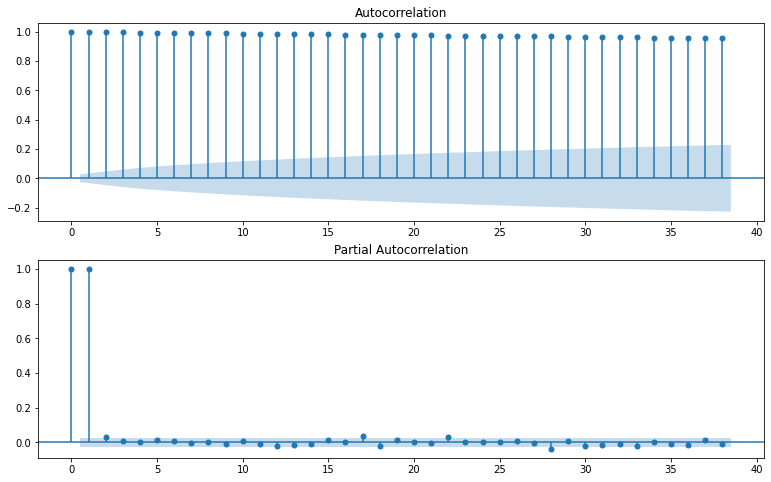

In [79]:
show_acf_pacf(timeseries[code_nongsim])

ACF를 보면, 값이 천천히 감소하는 형태를 보인다.<br/>
PACF의 경우 lag 2 이후로, 값이 0으로 절단 된 형태를 보인다.<br/>
따라서 AR을 초기모델로 선정하며, 모수의 초기값은 *p=1, q=0* 이 적절하다.

- Differencing

Results of Dickey-Fuller Test:
Test Statistic                  -53.987062
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    5317.000000
Critical Value (1%)              -3.431580
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567059
dtype: float64


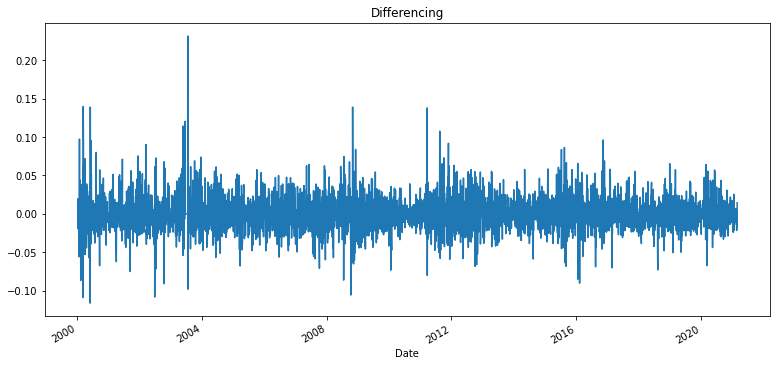

In [80]:
diff_1_nongsim = differencing(timeseries[code_nongsim], 2)

일차 차분의 결과의 *p-value*는 매우 작은 값으로 충분히 안정화된 상태가 되었으므로 *d*의 초기값으로는 *1*이 적절하다.

#### 4. ARIMA 모델 훈련과 테스트

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4787
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11643.430
Method:                       css-mle   S.D. of innovations              0.021
Date:                Thu, 04 Mar 2021   AIC                         -23280.860
Time:                        03:17:41   BIC                         -23261.439
Sample:                             1   HQIC                        -23274.038
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.343      0.179      -0.000       0.001
ar.L1.D.Close    -0.0605      0.014     -4.187      0.000      -0.089      -0.032
                                    Root

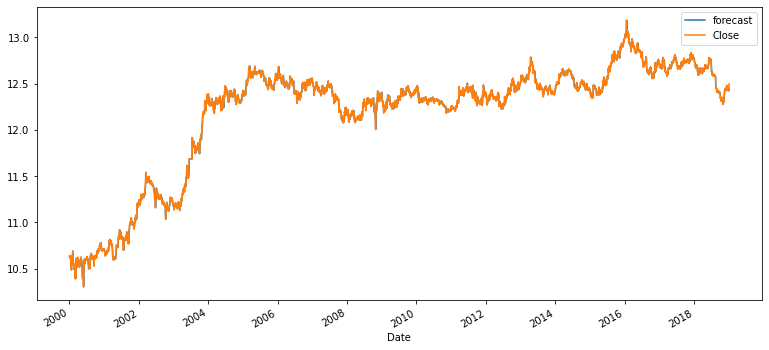

In [81]:
fitted_m_nongsim = train_arima(train_data_nongsim, (1, 1, 0))

- 모델 테스트 및 플로팅

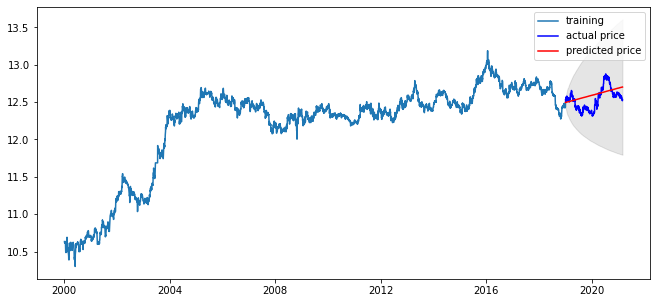

In [82]:
fc_series_nongsim, _, _ = predict_arima(fitted_m_nongsim,
                                        test_data_nongsim,
                                        train_data_nongsim, 2)

- 예측 모델 정확도 측정

In [83]:
_ = get_model_accuracy(test_data_nongsim, fc_series_nongsim)

MSE:  1538405328.2025132
MAE:  33929.34006479728
RMSE:  39222.51047807258
MAPE: 12.42%


MAPE 값이 12.42%로 목표치인 10%와의 차이가 크므로 모델을 개선할 필요가 있다. 

#### 5. 모델개선
📝 모수 재설정을 위한 **grid search** 수행

  0%|          | 0/36 [00:00<?, ?it/s]

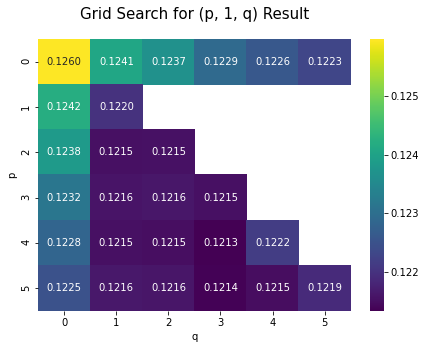

In [84]:
gride_search_scores_1 = grid_search(train_data_nongsim,
                                    test_data_nongsim,
                                    range(6), 1, range(6),
                                    verbose=2)

  0%|          | 0/25 [00:00<?, ?it/s]

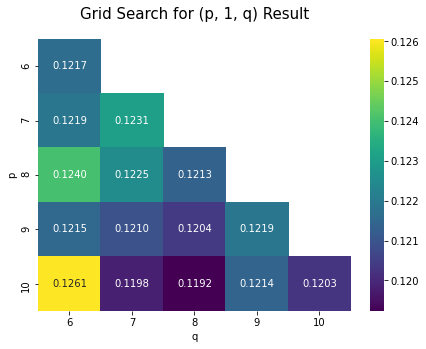

In [126]:
gride_search_scores_2 = grid_search(train_data_nongsim,
                                    test_data_nongsim,
                                    range(6,11), 1, range(6,11),
                                    verbose=2)

p와 q를 [0. 10] 범위에서 gride search를 수행한 결과 (p, q) = (10, 8)일 때, MAPE = 11.92%로 가장 낮은 수치를 기록하였다.

📝 **외생변수** 추가<br> 
KOSPI 지수를 외생변수로  추가하여 ARIMAX 모델을 생성한다.

- train / test 데이터 분리

In [85]:
train_kospi_nongsim_ts = kospi_ts.iloc[lambda x : x.index.isin(train_data_nongsim.index)]
test_kospi_nongsim_ts = kospi_ts.iloc[lambda x : x.index.isin(test_data_nongsim.index)]

print(f'KOSPI timeserise - train : {train_kospi_nongsim_ts.shape}')
print(f'KOSPI timeserise - test : {test_kospi_nongsim_ts.shape}')

KOSPI timeserise - train : (4788,)
KOSPI timeserise - test : (532,)


- ARIMA 모델 학습 : (p, d, q) = (1, 1, 0)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4787
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11645.145
Method:                       css-mle   S.D. of innovations              0.021
Date:                Thu, 04 Mar 2021   AIC                         -23282.291
Time:                        03:22:57   BIC                         -23256.396
Sample:                             1   HQIC                        -23273.195
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0088      0.005      1.937      0.053      -0.000       0.018
Close            -0.0012      0.001     -1.854      0.064      -0.002     6.6e-05
ar.L1.D.Close    -0.0613      0.014     

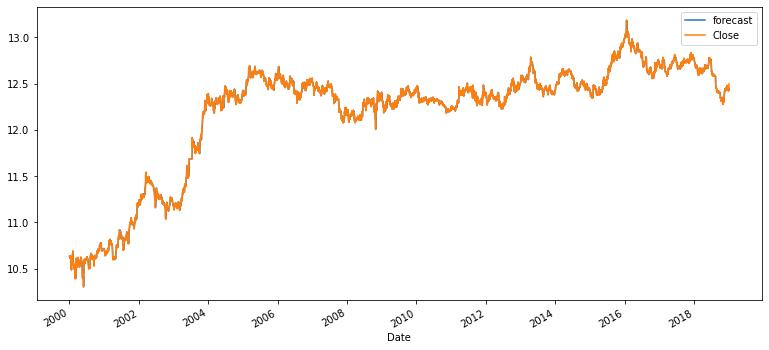

In [86]:
fitted_m_nongsim_arimax = train_arima(train_data_nongsim, 
                                      (1,1,0), 
                                      exog=train_kospi_nongsim_ts)

- 예측

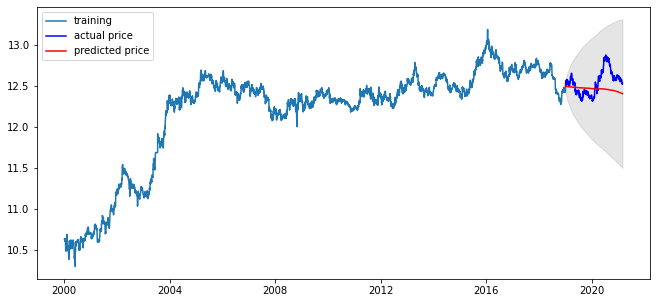

In [88]:
fc_series_nongsim_arimax, _, _ = predict_arima(fitted_m_nongsim_arimax, 
                                          test_data_nongsim, 
                                          exog=test_kospi_nongsim_ts,
                                          train_data=train_data_nongsim,
                                          verbose=2)

- 예측 결과의 정확도 평가

In [90]:
_ = get_model_accuracy(test_data_nongsim, fc_series_nongsim_arimax)

MSE:  2505070292.3933935
MAE:  38956.589277790925
RMSE:  50050.67724210526
MAPE: 12.82%


- Grid Search를 통한 모수 탐색

  0%|          | 0/36 [00:00<?, ?it/s]

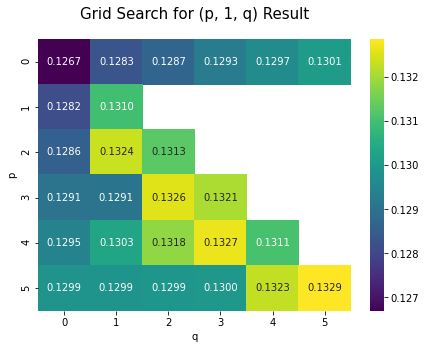

In [92]:
gride_search_scores_arimax_1 = grid_search(train_data_nongsim, 
                                           test_data_nongsim, 
                                           range(6), 1, range(6), 
                                           exog_train=train_kospi_nongsim_ts, 
                                           exog_test=test_kospi_nongsim_ts, 
                                           verbose=2)

p와 q를 [0. 5] 범위에서 gride search를 수행한 결과 (p, q) = (0, 0)일 때, MAPE = 12.67%로 가장 낮은 수치를 기록하였다. 이런 경우를 ***확률보행(Random Walk)*** 라고하며, 어디로 튈지 불안정하며 바로 직전 시점의 데이터가 영향을 끼치게 되고, 이는 주식 데이터와 일맥상통한 면이 있다.

📝 **EDA**<br>
test dataset의 크기가 30이 되도록 조정한 후, 다시 학습을 시켜보자.

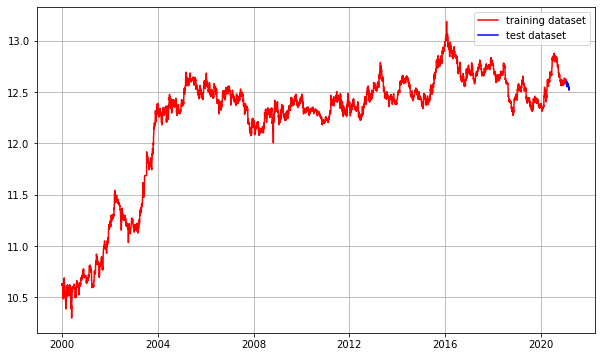

((5290,), (30,))

In [100]:
train_data_nongsim_2, test_data_nongsim_2 = split_train_and_test(
                                                timeseries[code_nongsim],
                                                train_ratio=0.9944,
                                                verbose=2)
train_data_nongsim_2.shape, test_data_nongsim_2.shape

- 모델 학습 및 평가

In [101]:
# 모델 훈련과 테스트
fitted_m_nongsim_2 = train_arima(train_data_nongsim_2, (1, 1, 0), verbose=0)

#모델 테스트 및 플로팅
fc_series_nongsim_2, _, _ = predict_arima(fitted_m_nongsim_2, test_data_nongsim_2, verbose=0)

#예측 모델 정확도 측정
_ = get_model_accuracy(test_data_nongsim_2, fc_series_nongsim_2)

MSE:  189730271.29687616
MAE:  12133.76611474516
RMSE:  13774.261188785269
MAPE: 4.27%


충분히 낮은 MAPE를 얻었기 때문에 더 이상의 더 이상 개선을하지는 않는다.

#### summary
- 농심의 주식 데이터를 활용하여 미래의 주식가격을 예측하는 ARIMA 모델을 구축하였다.
- 아래과 같은 시도들을 하였고, 각 시도마다 계산된 MAPE 값도 함께 나열하였다.

| 시도 | 데이터 처리 | p, d, q  | MAPE(%) |
|:-----|----------|:-------|:-----:|
| ARIMA 초기 모델 | 정규화(로그변환)<br> train : test = 9 : 1 | 1,1,0 | 12.42 | 
| Grid Search | 정규화(로그변환)<br> train : test = 9 : 1  | 찾아낸 optimal :  10,1,8 | 11.92 |
| ARIMAX, 외생변수(KOSPI) 추가 | 정규화(로그변환)<br> train : test = 9 : 1 | 1, 1, 0 | 12.82|
| ARIMAX, Grid Search | 정규화(로그변환)<br> train : test = 9 : 1 | 찾아낸 optimal : 0, 1, 0 | 12.67 |
| EDA | 정규화(로그변환)<br> train : test = 5290 : 30 | 1, 1, 0 | 4.27 |

### 036570.KS - Ncsoft Corporation

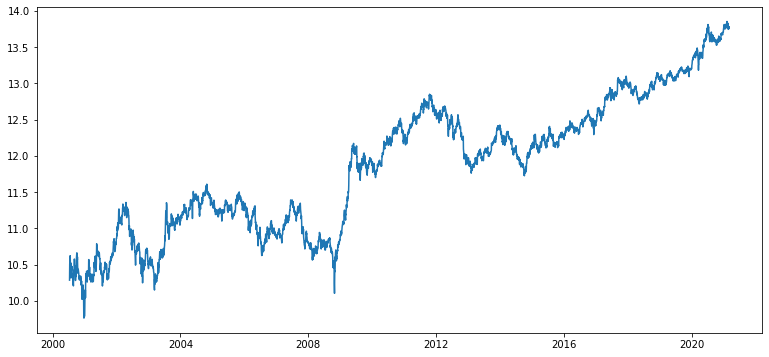

In [102]:
code_nc = '036570.KS'
show_series_plt(timeseries[code_nc])

#### 1. 데이터 안정성 분석

- 정성적 그래프 분석

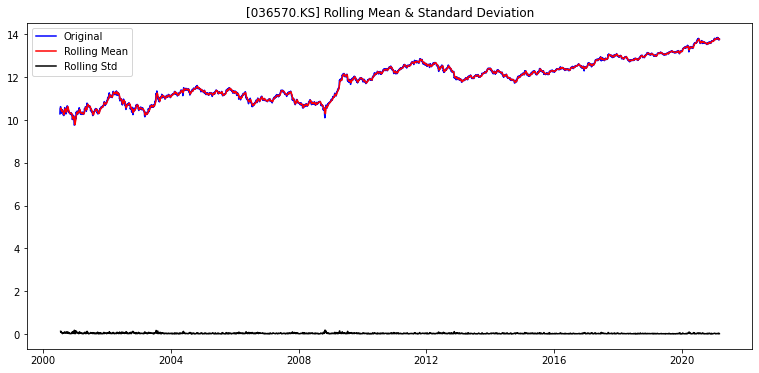

In [103]:
plot_rolling_statistics(timeseries[code_nc], code_nc, window=7)

그래프상으로 평균은 점진적으로 증가하고, 분산은 일정하므로 데이터는 현재 안정적이지 않은 상태이다.

- Augmented Dicky-Fuller Test

In [104]:
augmented_dickey_fuller_test(timeseries[code_nc])

Results of Dickey-Fuller Test:
Test Statistic                   -0.665037
p-value                           0.855599
#Lags Used                       14.000000
Number of Observations Used    5169.000000
Critical Value (1%)              -3.431616
Critical Value (5%)              -2.862099
Critical Value (10%)             -2.567068
dtype: float64


ADFTest의 결과 p-value가 0.05 미만의 낮은 값을 가지지 않으므로, 이 결과로 데이터가 안정적임을 확인 할 수 없다.

- 시계열 분해(Time Series Decomposition)

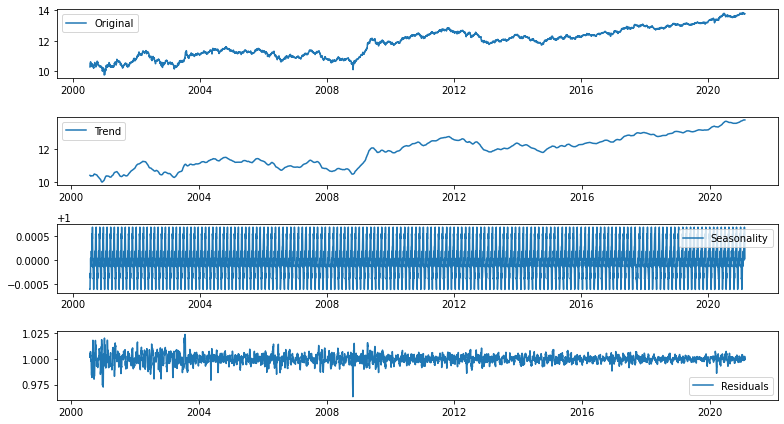

In [125]:
trend, seasonal, residual = time_series_decomposition(timeseries[code_nc], period=30)

- Residual 분석

In [106]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -20.182128
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5144.000000
Critical Value (1%)              -3.431622
Critical Value (5%)              -2.862102
Critical Value (10%)             -2.567069
dtype: float64


#### 2. 학습, 테스트 데이터셋 생성

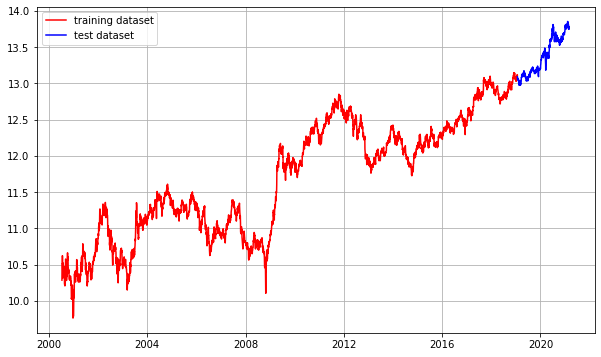

In [107]:
train_data_nc, test_data_nc = split_train_and_test(timeseries[code_nc], verbose=2)

#### 3.초기 ARIMA 모수 찾기
- ACF, PACF

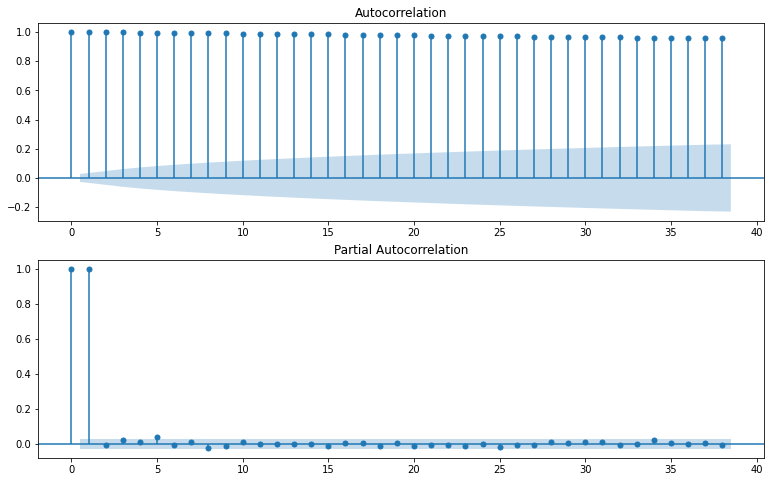

In [109]:
show_acf_pacf(timeseries[code_nc])

ACF를 보면, 값이 천천히 감소하는 형태를 보인다.<br/>
PACF의 경우 lag 2 이후로, 값이 0으로 절단 된 형태를 보인다.<br/>
따라서 AR을 초기모델로 선정하며, 모수의 초기값은 *p=1, q=0* 이 적절하다.

- Differencing

Results of Dickey-Fuller Test:
Test Statistic                  -19.695200
p-value                           0.000000
#Lags Used                       13.000000
Number of Observations Used    5169.000000
Critical Value (1%)              -3.431616
Critical Value (5%)              -2.862099
Critical Value (10%)             -2.567068
dtype: float64


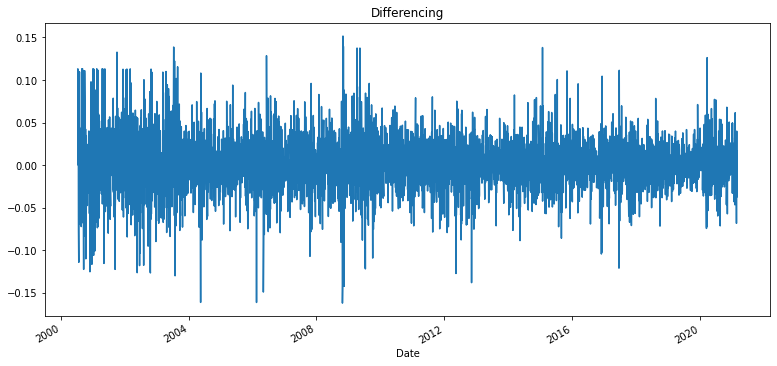

In [110]:
diff_1_nc = differencing(timeseries[code_nc], 2)

일차 차분의 결과의 *p-value*는 0으로 충분히 안정화된 상태가 되었으므로 *d*의 초기값으로는 *1*이 적절하다.

#### 4. ARIMA 모델 훈련과 테스트

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4664
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9414.028
Method:                       css-mle   S.D. of innovations              0.032
Date:                Thu, 04 Mar 2021   AIC                         -18822.056
Time:                        04:34:23   BIC                         -18802.713
Sample:                             1   HQIC                        -18815.252
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      1.221      0.222      -0.000       0.002
ar.L1.D.Close     0.0547      0.015      3.738      0.000       0.026       0.083
                                    Root

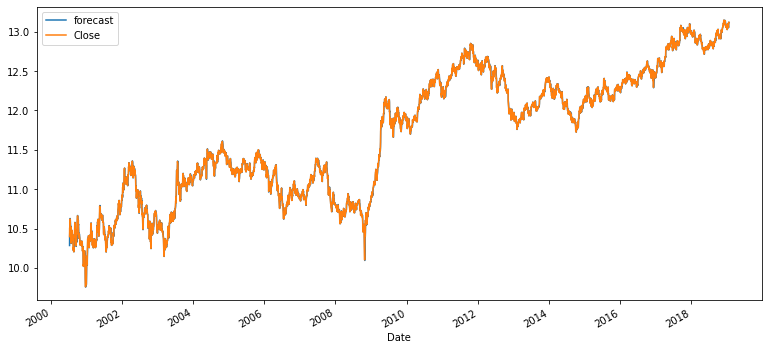

In [111]:
fitted_m_nc = train_arima(train_data_nc, (1, 1, 0))

- 모델 테스트 및 플로팅

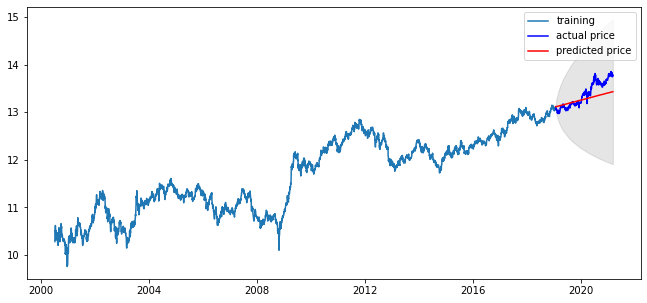

In [112]:
fc_series_nc, _, _ = predict_arima(fitted_m_nc, test_data_nc, 
                                   train_data=train_data_nc, 
                                   verbose=2)

- 예측 모델 정확도 측정

In [113]:
_ = get_model_accuracy(test_data_nc, fc_series_nc)

MSE:  21770622606.085632
MAE:  110294.24186280768
RMSE:  147548.71265478947
MAPE: 14.38%


MAPE 값이 14.38%로 목표치인 10%와의 차이가 크므로 모델을 개선할 필요가 있다. 

#### 5. 모델개선
📝 모수 재설정을 위한 **grid search** 수행

  0%|          | 0/36 [00:00<?, ?it/s]

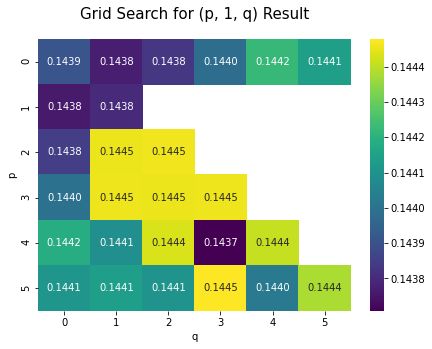

In [115]:
gride_search_scores_nc_1 = grid_search(train_data_nc, 
                                       test_data_nc, 
                                       range(6), 1, range(6), 
                                       verbose=2)

  0%|          | 0/25 [00:00<?, ?it/s]

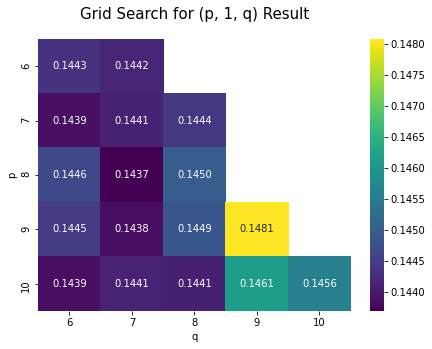

In [127]:
gride_search_scores_nc_1 = grid_search(train_data_nc, 
                                       test_data_nc, 
                                       range(6, 11), 1, range(6, 11), 
                                       verbose=2)

p와 q를 [0. 10] 범위에서 gride search를 수행한 결과 (p, q) = (8, 7)일 때, MAPE = 14.37%로 가장 낮은 수치를 기록하였다.

📝 **외생변수** 추가<br> 
KOSPI 지수를 외생변수로  추가하여 ARIMAX 모델을 생성한다.

- train / test 데이터 분리

In [116]:
train_kospi_nc_ts = kospi_ts.iloc[lambda x : x.index.isin(train_data_nc.index)]
test_kospi_nc_ts = kospi_ts.iloc[lambda x : x.index.isin(test_data_nc.index)]

print(f'KOSPI timeserise - train : {train_kospi_nc_ts.shape}')
print(f'KOSPI timeserise - test : {test_kospi_nc_ts.shape}')

KOSPI timeserise - train : (4665,)
KOSPI timeserise - test : (519,)


- ARIMA 모델 학습 : (p, d, q) = (1, 1, 0)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4664
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9414.033
Method:                       css-mle   S.D. of innovations              0.032
Date:                Thu, 04 Mar 2021   AIC                         -18820.067
Time:                        04:39:17   BIC                         -18794.276
Sample:                             1   HQIC                        -18810.996
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.008      0.184      0.854      -0.014       0.017
Close            -0.0001      0.001     -0.107      0.915      -0.002       0.002
ar.L1.D.Close     0.0547      0.015     

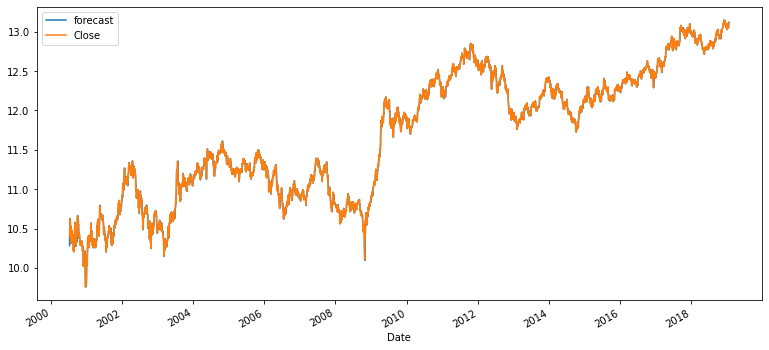

In [117]:
fitted_m_nc_arimax = train_arima(train_data_nc, 
                                 (1,1,0),
                                 exog=train_kospi_nc_ts)

- 예측

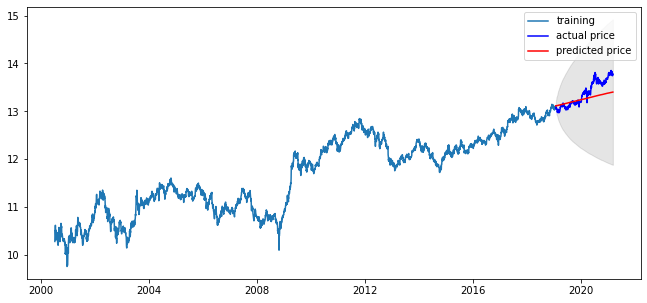

In [118]:
fc_series_nc_arimax, _, _ = predict_arima(fitted_m_nc_arimax, 
                                          test_data_nc, 
                                          exog=test_kospi_nc_ts,
                                          train_data=train_data_nc,
                                          verbose=2)

- 예측 결과의 정확도 평가

In [119]:
_ = get_model_accuracy(test_data_nc, fc_series_nc_arimax)

MSE:  24162268058.425503
MAE:  115171.89722928405
RMSE:  155442.16949858074
MAPE: 14.88%


- Grid Search를 통한 모수 탐색

  0%|          | 0/36 [00:00<?, ?it/s]

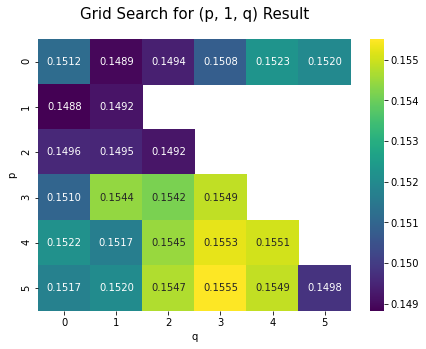

In [120]:
gride_search_scores_arimax_nc = grid_search(train_data_nc, 
                                           test_data_nc, 
                                           range(6), 1, range(6), 
                                           exog_train=train_kospi_nc_ts, 
                                           exog_test=test_kospi_nc_ts, 
                                           verbose=2)

p와 q를 [0. 5] 범위에서 gride search를 수행한 결과 (p, q) = (1, 0)일 때, MAPE = 14.88%로 가장 낮은 수치를 기록하였다. 

📝 **EDA**<br>
test dataset의 크기가 30이 되도록 조정한 후, 다시 학습을 시켜보자.

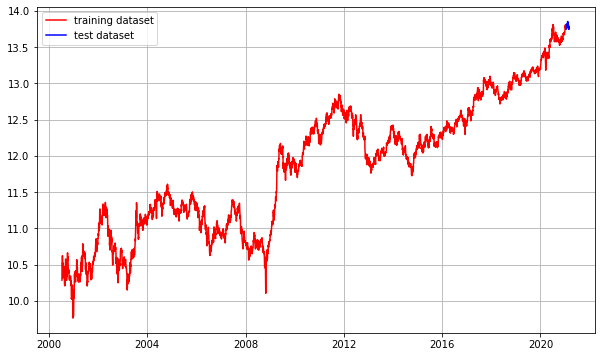

((5154,), (30,))

In [123]:
train_data_nc_2, test_data_nc_2 = split_train_and_test(timeseries[code_nc],
                                                       train_ratio=0.9943,
                                                       verbose=2)
train_data_nc_2.shape, test_data_nc_2.shape

- 모델 학습 및 평가

In [124]:
# 모델 훈련과 테스트
fitted_m_nc_2 = train_arima(train_data_nc_2, (1, 1, 0), verbose=0)

#모델 테스트 및 플로팅
fc_series_nc_2, _, _ = predict_arima(fitted_m_nc_2, test_data_nc_2, verbose=0)

#예측 모델 정확도 측정
_ = get_model_accuracy(test_data_nc_2, fc_series_nc_2)

MSE:  1770472260.2456596
MAE:  35294.30322290596
RMSE:  42076.9801702268
MAPE: 3.56%


충분히 낮은 MAPE를 얻었기 때문에 더 이상의 더 이상 개선을 진행하지는 않는다.

#### summary
- NC의 주식 데이터를 활용하여 미래의 주식가격을 예측하는 ARIMA 모델을 구축하였다.
- 아래과 같은 시도들을 하였고, 각 시도마다 계산된 MAPE 값도 함께 나열하였다.

| 시도 | 데이터 처리 | p, d, q  | MAPE(%) |
|:-----|----------|:-------|:-----:|
| ARIMA 초기 모델 | 정규화(로그변환)<br> train : test = 9 : 1 | 1,1,0 | 14.38 | 
| Grid Search | 정규화(로그변환)<br> train : test = 9 : 1  | 찾아낸 optimal :  8,1,7 | 14.37 |
| ARIMAX, 외생변수(KOSPI) 추가 | 정규화(로그변환)<br> train : test = 9 : 1 | 1, 1, 0 | 14.88 |
| ARIMAX, Grid Search | 정규화(로그변환)<br> train : test = 9 : 1 | 찾아낸 optimal : 1, 1, 0 | 14.88 |
| EDA | 정규화(로그변환)<br> train : test = 5154 : 30 | 1, 1, 0 | 3.56 |

## STEP 3. 결론
---

### 프로젝트 평가
1. 시계열의 안정성이 충분히 확인되었는가?
    - 데이터의 안정성을 확인하기 위하여, 데이터의 평균/분산을 그래프로 나타내어 보았다.
    - 데이터의 안정성을 확인하기 위하여, Augmented Dicky-Fuller Test(이하 ADFTest)를 구해보았다.
    - 데이터의 안정성을 확인하기 위하여, 시계열 분해를 진행하고 residual을 확인하였다.
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
    - ARIMA의 모수 p, q의 초기값 선정에는 데이터의 ACF와 PACF 사용되었다. 
    - ARIMA의 모수 d의 경우, 데이터를 차분하고 그에 대해 ADFTest를 수행하여 얻은 p-value를 사용하여 값을 선정하였다.
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
    - 삼성 6.57%, 농심 4.27%, NC 3.56%로 세가지 데이터에 대하여 10% 이하의 오차율을 기록하였다.

### 회고
- 이번 프로젝트에서 어려웠던 점은 주제 자체가 까다롭다는 것이었다. 근 일년 사이의 주식은 코로나의 영향으로 급격한 하향세 후 반등하는 경향을 보이고 있다. 즉, 최근의 주식 데이터에는 특별한 이벤트가 과거 자신의 기록보다 더 큰 영향을 미치고 있기에 ARIMA 모델이 제대로 작동할지부터가 의문이었다. 이런 특정한 외부요소를 반영할 수 있는 방법이 있을까 하다가 알게 된 것이  ARIMA 모델에 외생변수를 적용하는 ARIMAX였다. 질병 데이터를 전체 기간에 적용하는 것은 무리가 있으므로 대체제로 KOSPI 지수를 외생변수로 사용하였다. 똑같은 외생변수를 적용하였을 때, 삼성전자의 경우 MAPE가 개선 되었으나 농심의 경우에는 오히려 MAPE가 악화되었다. 어떠한 요소가 이런 결과를 만들어 냈는지에 대한 정확한 해석이 현재로써는 불가능하여 답답함을 느꼈고 이 부분은 더 공부해봐야 겠다는 생각이 들었다🤔
- 시계열 분해가 된 데이터를 모델에 사용하지 않는 이유는 계절성을 유지하기 위함일까?
- auto.arima : ARIMA의 모수를 추정하는 것에 있어서 좀 더 확실한 결과를 얻고 싶다는 생각이 들어 ARIMA 모델의 모수를 자동으로 추정해주는 `auto.arima`를 시도해보았다. 큰 기대를 안고 패키지를 동작시켰지만, 아래의 코드 실행 output과 같은 결과를 얻게 되었다. 해당 패키지의 document에서는 start_p에서 max_p 사이의 범위에서 최적의 p를 탐색한다고 서술되어 있었다. 하지만 출력된 로그를 보면, 최초의 시도만 파라미터(start_p, max_p)로 입력한 범위에서 동작하고 이후로는 defalt로 지정된 범위(0~5)로 돌아가서 동작하는 것이 관찰되었다. default를 넘어서는 범위에 대해서 search가 불가능한데 그 default 범위도 충분히 크지 않기에, 프로젝트에 적용시키기 어려웠다. 내가 사용법을 착각하고 있기 때문인지, 정말 패키지 자체의 결함인지는 더 확인해볼 필요가 있는 것 같다.

In [128]:
from pmdarima.arima import auto_arima

# m=0 : non-seasonal
stepwise_model = auto_arima(train_data_ss,
                            trace=True, 
                            error_action='ignore', 
                            start_p=5, start_q=5,
                            max_p=10, max_q=10,
                            suppress_warnings=True,
                            stepwise=True,
                            seasonal=False)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=-22577.711, Time=2.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22541.725, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22548.822, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22550.138, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22542.372, Time=0.12 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=-22579.653, Time=1.68 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=-22581.524, Time=2.43 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=-22583.379, Time=5.88 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=-22585.503, Time=5.37 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-22587.460, Time=1.73 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-22588.930, Time=1.79 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-22580.377, Time=1.34 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-22587.533, Time=2.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-22587.651, Time=1.86 sec
 ARIM

## ref
---
- [ARIMA 모델 개요 - Part 1](https://youtu.be/ma_L2YRWMHI)
- [ARIMA 모델 개요 - Part 2](https://youtu.be/P_3808Xv76Q)
- [시계열(Time series) > ARIMAX, SARIMA, SARIMAX](https://direction-f.tistory.com/70)
- [시계열(Time series) > Forecasting](https://direction-f.tistory.com/71)
- [6.Tips to using auto_arima](https://alkaline-ml.com/pmdarima/0.9.0/tips_and_tricks.html)
- [Time Series Forecasting with ARIMA](https://h3imdallr.github.io/2017-08-19/arima/)
- [ARIMA model for time series forecasting(시계열 분석)](https://kimginam1995.tistory.com/557)
- [29가지 통계 개념 - Akaike's Information Criterion(AIC)의 정의와 공식](https://chukycheese.github.io/statistics/aic/)
- [Forecasting: Principles and Practice](https://otexts.com/fppkr/)
- [ARIMA basics-Time-Series Analysis(2)](https://ohjinjin.github.io/dataanalysis/time-series-2/)
- [ARIMA 모델 Python 실습](https://youtu.be/rdR2fNDq6v0)